## Семинар 7: "Методы оптимизации"

ФИО:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.autograd import Variable
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [24]:
class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    def zero_grad(self):
        for param in self.parameters:      
            param.grad.zero_()
  
    def step(self, F):
        loss = F()
        loss.backward()        

        
class SGD(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for param in self.parameters:
                param -= self.learning_rate * param.grad
                
class Momentum(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.v = [torch.zeros_like(param) for param in self.parameters]
        
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v
                
class NAG(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.v = [torch.zeros_like(param) for param in self.parameters]
        
        self.gamma = gamma
    
    def step(self, F):
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param -= v
        
        super().step(F)
        
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param += v
                
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                
                param -= v

class Adagrad(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-9
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for G, param in zip(self.G, self.parameters):
                G.copy_(G + param.grad**2)
                
                param -= self.learning_rate / torch.sqrt(G + self.eps)  * param.grad 

class Adadelta(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate

        self.G = [torch.zeros_like(param) for param in self.parameters]
      
        self.delta = [torch.ones_like(param) for param in self.parameters]
        self.eps = 10e-8

        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for G, delta, param in zip(self.G, self.delta, self.parameters):
                G.copy_(self.gamma * G + (1 - self.gamma) * param.grad**2)
                
                g = torch.sqrt(delta + self.eps) * param.grad / torch.sqrt(G + self.eps)

                param -= g

                delta.copy_(self.gamma * delta + (1 - self.gamma) * g**2)

class RMSProp(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate * 10
        
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-9
        
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad

class Adam(Optimizer):
    def __init__(self, parameters, learning_rate=0.1, beta1=0.9, beta2=0.999):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.m = [torch.zeros_like(param) for param in self.parameters]
        self.v = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-9
        
        self.beta1 = beta1
        self.beta2 = beta2

        self.beta1_ = self.beta1
        self.beta2_ = self.beta2
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for m, v, param in zip(self.m, self.v, self.parameters):
                m.copy_(self.beta1 * m + (1 - self.beta1) * param.grad)
                v.copy_(self.beta2 * v + (1 - self.beta2) * param.grad**2)
                
                m_mean = m / (1 - self.beta1_)
                v_mean = v / (1 - self.beta2_)
                param -= self.learning_rate / (torch.sqrt(v_mean) + self.eps) * m_mean

                self.beta1_ *= self.beta1
                self.beta2_ *= self.beta2

In [40]:
x_0 = np.array([2.5, 1.5]).reshape(1, -1)

def F(x):
    #return (x**2).sum(-1)
    
    x, y = x[:, 0], x[:, 1]
    
    return x**2 + y**2

optimizers = [SGD, Momentum, NAG, RMSProp, Adagrad, Adam, Adadelta]
colors = ["red", "blue", "yellow", "pink", "green", "cyan", "magenta"]

optim_path = []

for optim in optimizers:
    print(optim.__name__)
    
    x = torch.tensor(x_0, requires_grad=True)
    if optim in [SGD, Momentum, NAG, RMSProp]:
      optim = optim([x], learning_rate=0.01)
    else:
      optim = optim([x], learning_rate=1)
    
    points = []
    
    for i in range(30):
        p_z = F(x).item()
        #print(p_z)
        
        p_x, p_y = x.detach().numpy().flatten()        
        print(p_z, p_x, p_y)
        points.append((p_x, p_y, p_z))

        optim.step(lambda: F(x))
        optim.zero_grad()
        
    optim_path.append(points)

SGD
8.5 2.5 1.5
8.163400000000001 2.45 1.47
7.840129360000001 2.4010000000000002 1.4405999999999999
7.529660237344 2.35298 1.4117879999999998
7.231485691945178 2.3059204 1.3835522399999998
6.9451188585441495 2.2598019920000003 1.3558811951999998
6.670092151745801 2.2146059521600003 1.3287635712959998
6.405956502536667 2.1703138331168 1.3021882998700798
6.152280625036214 2.126907556454464 1.2761445338726782
5.90865031228478 2.0843694053253747 1.2506216431952246
5.674667759918303 2.0426820172188673 1.22560921033132
5.449950916625538 2.00182837687449 1.2010970261246936
5.234132860327167 1.9617918093370001 1.1770750856021996
5.026861199058211 1.9225559731502602 1.1535335838901557
4.827797495575505 1.8841048536872549 1.1304629122123526
4.636616714750716 1.8464227566135099 1.1078536539681056
4.4530066928465875 1.8094943014812397 1.0856965808887435
4.2766676278098625 1.7733044154516149 1.0639826492709687
4.107311589748592 1.7378383271425826 1.0427029962855494
3.9446620507945482 1.703081560599

In [7]:
R = 2
N = 21

space = np.linspace(R, -R, N)
X, Y = np.meshgrid(space, space)

Z = F(np.array([X.flatten(), Y.flatten()]).T).reshape(N, N)

TypeError: ignored

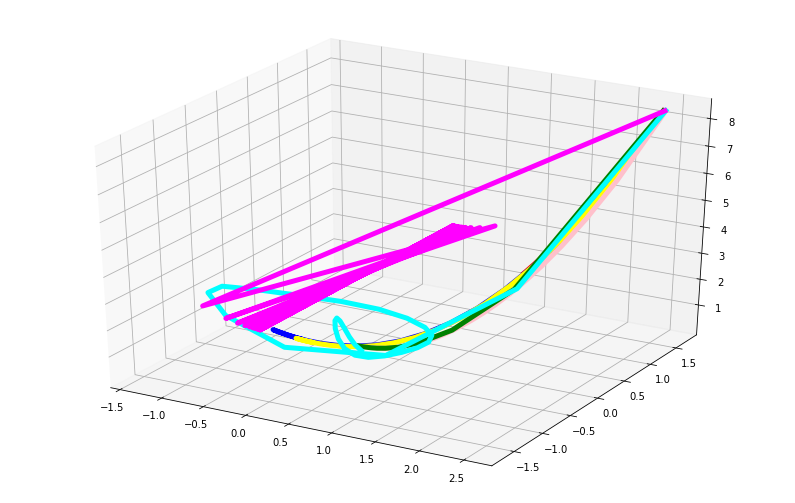

In [41]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
#ax.plot_wireframe(space, space, Z)

for color, path in zip(colors, optim_path):
    points = np.array(path)
    #print(points)
    points += np.random.rand(3) * 0.04
    ax.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=5)

"""
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
"""

#ax.view_init(30, 45)
plt.show()

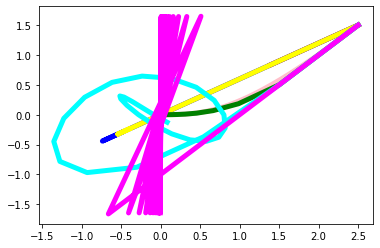

In [42]:
for color, path in zip(colors, optim_path):
    points = np.array(path)        
    plt.plot(points[:, 0], points[:, 1], color=color, linewidth=5)

In [30]:
np.array(optim_path).shape

(7, 30, 3)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [ ]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])



<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [43]:
x_0 = np.array([2.5, 1.5]).reshape(1, -1)

def F(x):
    #return (x**2).sum(-1)
    
    x, y = x[:, 0], x[:, 1]
    
    return x**2 * torch.sin(x) + y**2 * torch.sin(y)

optimizers = [SGD, Momentum, NAG, RMSProp, Adagrad, Adam, Adadelta]
colors = ["red", "blue", "yellow", "pink", "green", "cyan", "magenta"]

optim_path = []

for optim in optimizers:
    print(optim.__name__)
    
    x = torch.tensor(x_0, requires_grad=True)
    if optim in [SGD, Momentum, NAG, RMSProp]:
      optim = optim([x], learning_rate=0.01)
    else:
      optim = optim([x], learning_rate=1)
    
    points = []
    
    for i in range(30):
        p_z = F(x).item()
        #print(p_z)
        
        p_x, p_y = x.detach().numpy().flatten()        
        print(p_z, p_x, p_y)
        points.append((p_x, p_y, p_z))

        optim.step(lambda: F(x))
        optim.zero_grad()
        
    optim_path.append(points)

SGD
5.9848146205088515 2.5 1.5
5.842870139911936 2.5201478687664856 1.4684835633643551
5.692044433883103 2.542439974380342 1.4370650072789342
5.5304603945936375 2.5671447619306282 1.4058267943983263
5.355546872625051 2.594571002644757 1.3748463813250709
5.163836040629929 2.6250746753423426 1.3441954640621392
4.950700679486109 2.6590669606537367 1.3139394092803076
4.7100121249203895 2.6970233896420726 1.2841368714853136
4.433695293281769 2.7394940590871233 1.2548395881401586
4.111154212031998 2.787114572891539 1.2260923382922906
3.7285430680261147 2.840616904263066 1.197933045494056
3.267870866113597 2.9008385540737938 1.1703930028208887
2.705966039822025 2.968726988329952 1.1434971964644518
2.0134159147530584 3.0453340612363906 1.117264704477012
1.15377652362174 3.1317915925302184 1.0917091484753765
0.08367859029094216 3.229254179695926 1.0668391781637045
-1.2450167155723402 3.3387889651401386 1.0426589711031067
-2.879191716824322 3.4611864259386924 1.0191687329768027
-4.85234623454221

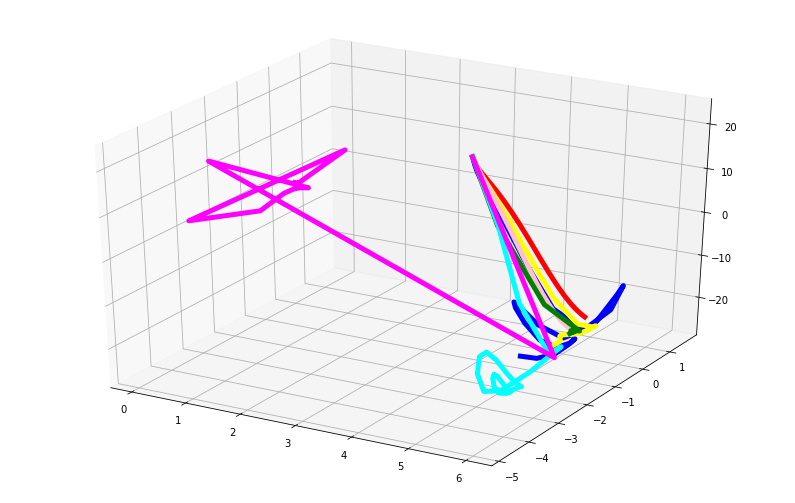

In [44]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
#ax.plot_wireframe(space, space, Z)

for color, path in zip(colors, optim_path):
    points = np.array(path)
    #print(points)
    points += np.random.rand(3) * 0.04
    ax.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=5)

"""
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
"""

#ax.view_init(30, 45)
plt.show()

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [45]:
x_0 = np.array([2.5, 1.5]).reshape(1, -1)

def F(x):
    #return (x**2).sum(-1)
    
    x, y = x[:, 0], x[:, 1]
    
    return x**2 * torch.sin(x**2) + y**2 * torch.sin(y**2)

optimizers = [SGD, Momentum, NAG, RMSProp, Adagrad, Adam, Adadelta]
colors = ["red", "blue", "yellow", "pink", "green", "cyan", "magenta"]

optim_path = []

for optim in optimizers:
    print(optim.__name__)
    
    x = torch.tensor(x_0, requires_grad=True)
    if optim in [SGD, Momentum, NAG, RMSProp]:
      optim = optim([x], learning_rate=0.01)
    else:
      optim = optim([x], learning_rate=1)
    
    points = []
    
    for i in range(30):
        p_z = F(x).item()
        #print(p_z)
        
        p_x, p_y = x.detach().numpy().flatten()        
        print(p_z, p_x, p_y)
        points.append((p_x, p_y, p_z))

        optim.step(lambda: F(x))
        optim.zero_grad()
        
    optim_path.append(points)

SGD
1.5432945895755925 2.5 1.5
-3.0684377205788853 2.1893310176322216 1.5190595236271474
-3.1750703724773506 2.216039161454947 1.5436602193608446
-3.2951014937738803 2.216582114362237 1.575809802743496
-3.5077948163555823 2.216569210912101 1.61842708414426
-3.895414487498419 2.2165695281575934 1.6757595223660873
-4.611492034686642 2.2165695203639415 1.75372384884703
-5.883449218258125 2.2165695205554092 1.8590470568770512
-7.743324648369699 2.2165695205507054 1.9927454758803005
-9.274200444314488 2.216569520550821 2.12901517520771
-9.62262517403407 2.2165695205508182 2.205403243890847
-9.628939469994688 2.2165695205508182 2.216647236277693
-9.628939779235967 2.2165695205508182 2.216567601958605
-9.628939779424424 2.2165695205508182 2.216569567679359
-9.628939779424538 2.2165695205508182 2.2165695193930035
-9.628939779424538 2.2165695205508182 2.216569520579262
-9.628939779424538 2.2165695205508182 2.2165695205501192
-9.628939779424538 2.2165695205508182 2.216569520550835
-9.62893977942

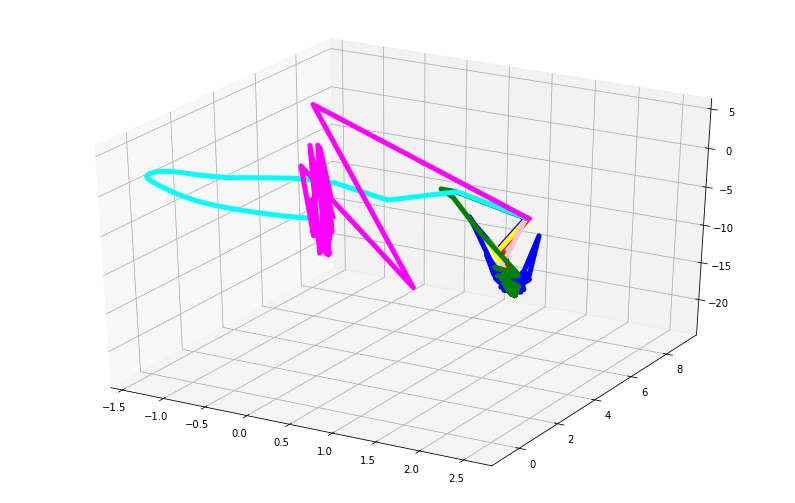

In [46]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
#ax.plot_wireframe(space, space, Z)

for color, path in zip(colors, optim_path):
    points = np.array(path)
    #print(points)
    points += np.random.rand(3) * 0.04
    ax.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=5)

"""
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
"""

#ax.view_init(30, 45)
plt.show()

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>

In [38]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2022-01-29 18:20:04--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2022-01-29 18:20:05--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [           <=>      ]  33.20M  6.51MB/s    in 5.6s    

2022-01-29 18:20:12 (5.93 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [39]:
transform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [47]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [69]:
import numpy as np
#from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
from IPython.display import clear_output

def _epoch(network, loss, loader,
           backward=True,
           optimizer=None,
           device='cpu',
           ravel_init=False):
    losses = []
    accuracies = []
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        if ravel_init:
            X = X.view(X.size(0), -1)
        network.zero_grad()
        prediction = network(X)
        
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.cpu().item())
        
        if backward:
            optimizer.step(lambda: loss_batch)
            optimizer.zero_grad()
        prediction = prediction.max(1)[1]
        accuracies.append((prediction==y).cpu().float().numpy().mean())
    return losses, accuracies


def train(network, train_loader, test_loader,
          epochs, learning_rate, optimizer, ravel_init=False,
          device='cpu', tolerate_keyboard_interrupt=True):
    loss = nn.NLLLoss()
    optimizer = optimizer(network.parameters(), learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network = network.to(device)
    try:
        for epoch in range(epochs):
            network.train()
            losses, accuracies = _epoch(network,
                                        loss,
                                        train_loader,
                                        True,
                                        optimizer,
                                        device,
                                        ravel_init)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            network.eval()
            losses, accuracies = _epoch(network,
                                        loss,
                                        test_loader,
                                        False,
                                        optimizer,
                                        device,
                                        ravel_init)

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

Epoch 0... (Train/Test) NLL: 1.017/0.463	Accuracy: 0.737/0.893


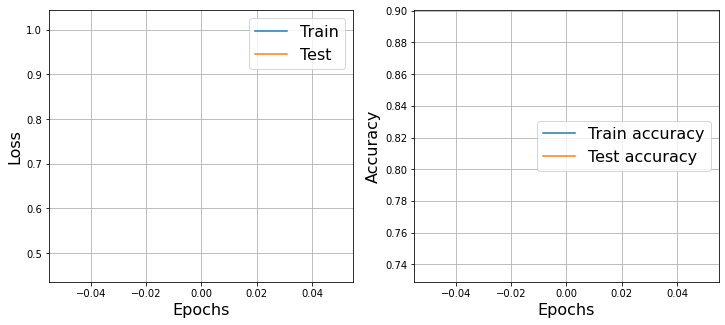

([1.0167509826978047], [0.4633458630440715], [0.7367833], [0.8926717])

In [76]:
layers = [nn.BatchNorm1d(196), nn.Linear(196, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Linear(128, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Linear(128, 10), nn.ReLU()]
network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, SGD)

Epoch 9... (Train/Test) NLL: 0.059/0.069	Accuracy: 0.981/0.981


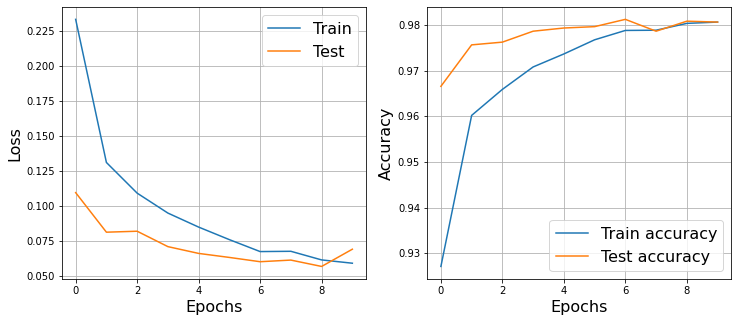

([0.23336370384792487,
  0.1309849578311046,
  0.10904485341807206,
  0.09478376092811426,
  0.08475526628233493,
  0.07577645616692802,
  0.06724090013566117,
  0.06743916502725333,
  0.0612742388293768,
  0.05891394116692245],
 [0.10940691322004928,
  0.08110848732423573,
  0.08179920242902951,
  0.0707771373829379,
  0.06592403852288573,
  0.06304792821713792,
  0.0599849716423246,
  0.06115022584901581,
  0.05660106855282447,
  0.06893224100925968],
 [0.9270833,
  0.9601833,
  0.9658833,
  0.9708,
  0.97365,
  0.97675,
  0.9788,
  0.97885,
  0.98035,
  0.9806333],
 [0.9665535,
  0.975639,
  0.976238,
  0.9786342,
  0.97933304,
  0.9796326,
  0.98123,
  0.9786342,
  0.98083067,
  0.980631])

In [71]:
network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001, Momentum)

Epoch 3... (Train/Test) NLL: 2.303/7733142868.714	Accuracy: 0.099/0.107


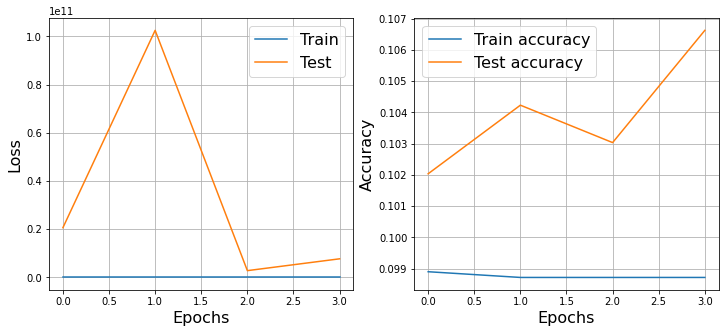

([10.587467613665263,
  2.3025851249694824,
  2.3025851249694824,
  2.3025851249694824],
 [20641489012.58671, 102543919428.9155, 2824980980.5204463, 7733142868.713934],
 [0.0989, 0.09871667, 0.09871667, 0.09871667],
 [0.102036744, 0.10423323, 0.103035145, 0.106629394])

In [77]:
network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001, Adadelta)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: